### Ladder network (https://arxiv.org/pdf/1501.02097.pdf)

Not done yet but shows small effect (but similar to original braess)?

In [171]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from src.traffic.v3.util.network import build_network
from src.traffic.v3.util.network import create_cars
from src.traffic.v3.environment import TrafficModel

In [172]:
def create_ladder_braess_graph(h, capacity=10):
    network = nx.DiGraph(
        [('s', 'v1'), ('s', 'w1'),
         (f'v{h}', 't'), (f'w{h}', 't'),
         (f'v{h-1}', f'v{h}'), (f'w{h-1}', f'w{h}')] +
        [(f'v{i-1}', f'v{i}') for i in range(2,h)] +
        [(f'w{i-1}', f'w{i}') for i in range(2,h)] +
        [(f'v{i}', f'w{i}') for i in range(1,h+1)]
    )

    nx.set_node_attributes(
        network, {
            's': (0.5, 0),
            **{f'v{i}': (0.4, i / h) for i in range(1, h)},
            **{f'w{i}': (0.6, i / h) for i in range(1, h)},
            f'v{h}': (0.4, 1),
            f'w{h}': (0.6, 1),
            't': (0.5, (1 / h) * (h + 1))
        }, "position"
    )

    nx.set_edge_attributes(
        network,
        {
            ('s', 'v1'): (6, 0, capacity, 1),
            ('s', 'w1'): (6, 6, capacity, 1),
            ('v1', 'v2'): (6, 6, capacity, 1),
            ('w1', 'w2'): (6, 0, capacity, 1),
            ('v2', 't'): (6, 0, capacity, 1),
            ('w2', 't'): (6, 6, capacity, 1),
            ('v1', 'w1'): (1, 0, capacity, 1),
            ('v2', 'w2'): (1, 0, capacity, 1),
        },
        "latency_params",
    )

    return build_network(network)

In [173]:
def draw_network(network):
    nx.draw(
        network,
        pos=nx.get_node_attributes(network, "position"),
        with_labels=True,
        font_size=8,
        edgelist=[(v, w) for v, w in network.edges if v != w]
    )

In [174]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

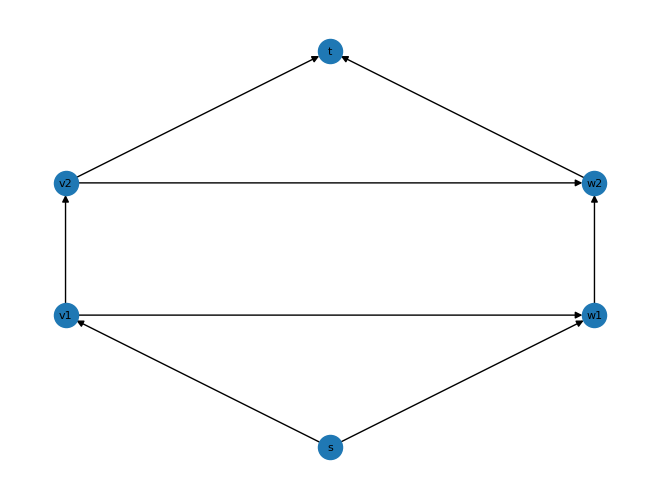

In [175]:
draw_network(create_ladder_braess_graph(2))

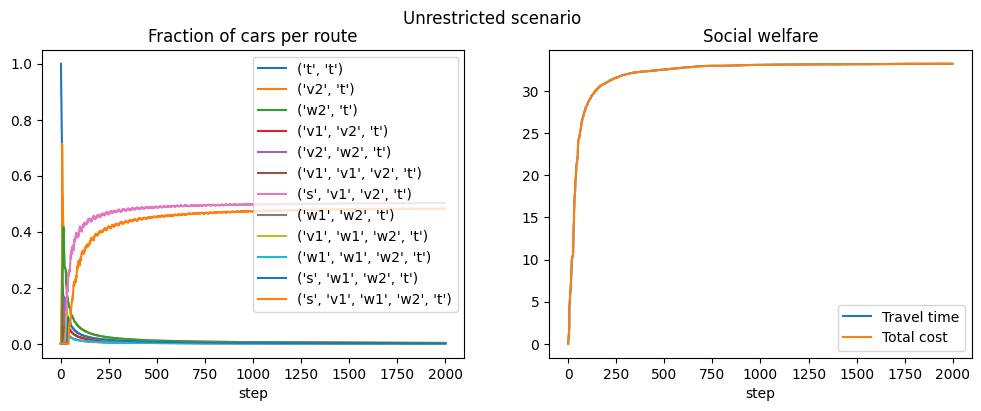

In [189]:
h = 2
number_of_steps = 2000
car_counts = {('s', 't'): 30}

network = create_ladder_braess_graph(h, capacity=4)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)

plot_results(car_stats_unrestricted, title='Unrestricted scenario')

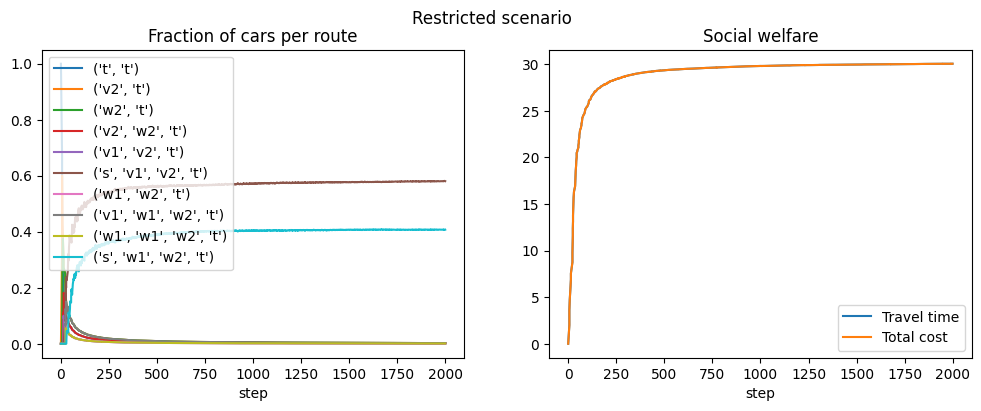

In [190]:
h = 2
number_of_steps = 2000
car_counts = {('s', 't'): 20}

network = create_ladder_braess_graph(h, capacity=4)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

# Close all edges of type A
model.set_edge_restriction((f'v1', f'w1'), False)
model.set_edge_restriction((f'v2', f'w2'), False)

step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)

plot_results(car_stats_restricted, title='Restricted scenario')

Text(0.5, 0.98, 'Travel time')

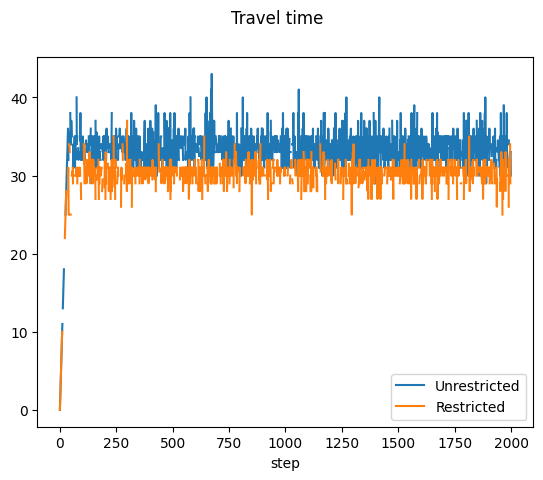

In [194]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted.groupby('step')['travel_time'].mean(),
    'Restricted': car_stats_restricted.groupby('step')['travel_time'].mean()}).plot(ax=ax, xlabel='step')

fig.suptitle("Travel time")